In [14]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from tqdm.auto import tqdm
import numpy as np
import json
import itertools
from sklearn import preprocessing

# == recnn ==
import sys
sys.path.append("../../../../")
import recnn

device = torch.device('cuda')

In [2]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
movies = {}
for i in omdb.keys():
    movies[i] = omdb[i]['omdb'].get('Actors', False).split(', ')

In [3]:
movie_embeddings_key_dict = pickle.load(open('../../../../data/embeddings/ml20_pca128.pkl', 'rb'))
movies_embeddings_tensor, key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)

In [4]:
actor_list = list(itertools.chain(*movies.values()))
le = list(set(sorted(actor_list)))


movies = dict([(k, list(map(le.index, i))) for k, i in tqdm(movies.items())])
actors = {}
for m in movies.keys():
    for a in movies[m]:
        if not actors.get(a, False):
            actors[a] = []
        actors[a].append(m)
actors = dict([(k, i) for k, i in tqdm(actors.items()) if len(i) > 3 ])

2019-09-11 17:26:40,299 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


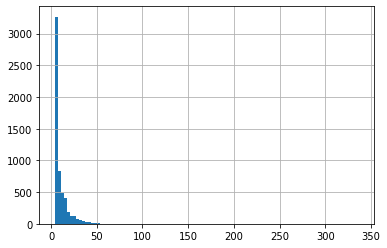

In [7]:
%matplotlib inline
import pandas as pd
pd.Series(map(len, actors.values())).hist(bins=100)

In [8]:
edge_index = list(set(itertools.chain(*[list(itertools.permutations(map(int, actors[i]), 2)) for i in tqdm(actors.keys())])))
edge_index = np.array(edge_index)
edge_index = torch.tensor(np.vectorize(key_to_id.get)(edge_index))

In [9]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
y = np.array(list(map(lambda x: float(x) if x !='N/A' else np.nan,
             [i['omdb'].get('imdbRating', np.nan) for i in omdb.values()])))

y[np.isnan(y)] = y[~np.isnan(y)].mean()
y = torch.tensor(y)

In [20]:
dataset = Data(x=movies_embeddings_tensor, edge_index=edge_index.t().contiguous(), y=y).to(device)
# dataset.train_idx = torch.tensor([...], dtype=torch.long)
# dataset.test_mask = torch.tensor([...], dtype=torch.uint8)

In [22]:
dataset

Data(edge_index=[2, 975154], x=[27279, 128], y=[27278])

In [23]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in tqdm(range(200)):
    for d in dataloader:
        print('a')
        #optimizer.zero_grad()
        #out = model(data)
        #loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        #loss.backward()
        #optimizer.step()

TypeError: getattr(): attribute name must be string